# Image Segmentation using UNet

## Import Libraries

In [51]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Load Data

In [52]:
DataPath = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

dirs = []
images = []
masks = []
for dirname, _, filenames in os.walk(DataPath):
    for filename in filenames:
        if 'mask'in filename:
            dirs.append(dirname.replace(DataPath, ''))
            masks.append(filename)
            images.append(filename.replace('_mask', ''))

In [53]:
print(masks[:5], images[:5])

['TCGA_DU_7010_19860307_56_mask.tif', 'TCGA_DU_7010_19860307_8_mask.tif', 'TCGA_DU_7010_19860307_34_mask.tif', 'TCGA_DU_7010_19860307_33_mask.tif', 'TCGA_DU_7010_19860307_43_mask.tif'] ['TCGA_DU_7010_19860307_56.tif', 'TCGA_DU_7010_19860307_8.tif', 'TCGA_DU_7010_19860307_34.tif', 'TCGA_DU_7010_19860307_33.tif', 'TCGA_DU_7010_19860307_43.tif']


In [54]:
len(dirs), len(images), len(masks)

(3929, 3929, 3929)

In [55]:
imagePath_df = pd.DataFrame({'directory':dirs, 'images': images, 'masks': masks})

In [56]:
imagePath_df.head()

,directory,images,masks
0,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_56.tif,TCGA_DU_7010_19860307_56_mask.tif
1,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_8.tif,TCGA_DU_7010_19860307_8_mask.tif
2,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_34.tif,TCGA_DU_7010_19860307_34_mask.tif
3,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_33.tif,TCGA_DU_7010_19860307_33_mask.tif
4,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_43.tif,TCGA_DU_7010_19860307_43_mask.tif


## Image Shape

In [57]:
def print_imShape():
    idx = np.random.randint(0, len(imagePath_df))
    
    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    print(image.shape, mask.shape)

In [58]:
for i in range(5):
    print_imShape()

(256, 256, 3) (256, 256, 3)
(256, 256, 3) (256, 256, 3)
(256, 256, 3) (256, 256, 3)
(256, 256, 3) (256, 256, 3)
(256, 256, 3) (256, 256, 3)


## Plot Images

In [59]:
def plot_images():
    idx = np.random.randint(0, len(imagePath_df))
    
    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    fig, axs = plt.subplots(1,3, figsize=[13,15])
    
    axs[0].imshow(image)
    axs[0].set_title('Brain MRI')
    
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    axs[2].imshow(image)
    axs[2].imshow(mask, alpha=0.3)
    axs[2].set_title('MRI with mask')
    
    plt.grid(False)
    plt.show()

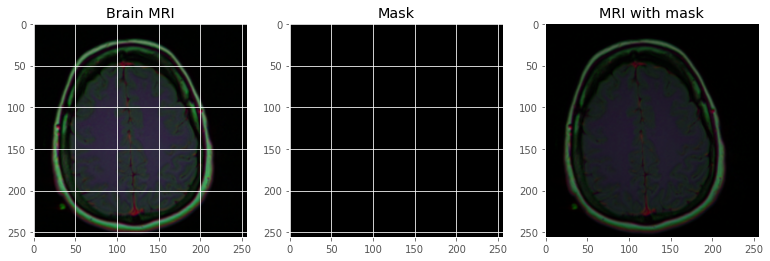

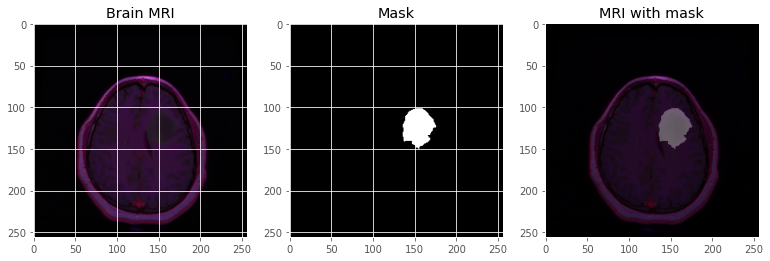

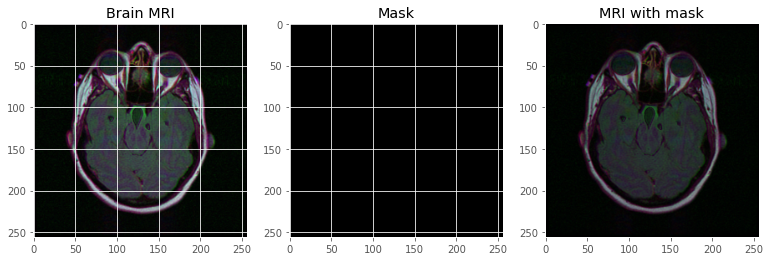

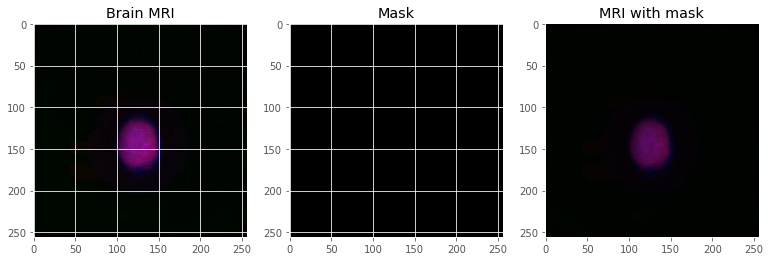

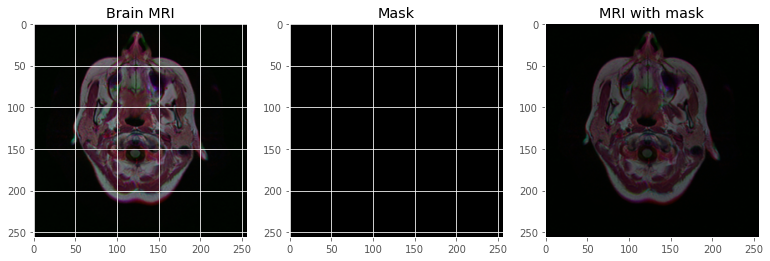

In [60]:
for i in range(5):
    plot_images()

Given the MRI Images of Brain our task is to identify if a tumor is present in the image or not. This problem boils down to image segmentation, which is extensively studied in the field of computer vision. Most popular use case is self driving cars

Above figure shows a sneak peak of what the data looks like. We have Brain MRIs labeled with a mask which indicates the presence of abnormality

## Config

In [61]:
imagePath_df['image-path'] = DataPath + imagePath_df['directory'] + '/' + imagePath_df['images']
imagePath_df['mask-path'] = DataPath + imagePath_df['directory'] + '/' + imagePath_df['masks'] 

In [62]:
train , test = train_test_split(imagePath_df, test_size=0.25, random_state=21)

In [63]:
EPOCHS = 20
BATCH_SIZE = 32
ImgHieght = 256
ImgWidth = 256
Channels = 3

## Data Generator

In [64]:
data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

### Train

In [65]:
imagegen = ImageDataGenerator(rescale=1./255., **data_augmentation)
maskgen = ImageDataGenerator(rescale=1./255., **data_augmentation)


timage_generator=imagegen.flow_from_dataframe(dataframe=train,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='rgb')
tmask_generator=maskgen.flow_from_dataframe(dataframe=train,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='grayscale')    

Found 2946 validated image filenames.
Found 2946 validated image filenames.


### Validation

In [66]:

imagegen = ImageDataGenerator(rescale=1./255.)
maskgen = ImageDataGenerator(rescale=1./255.)

vimage_generator=imagegen.flow_from_dataframe(dataframe=test,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='rgb')

vmask_generator=maskgen.flow_from_dataframe(dataframe=test,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='grayscale')    

Found 983 validated image filenames.
Found 983 validated image filenames.


In [67]:
def data_iterator(image_gen, mask_gen):
    for img, mask in zip(image_gen, mask_gen):
        yield img, mask

In [68]:
train_gen = data_iterator(timage_generator, tmask_generator)
valid_gen = data_iterator(vimage_generator, vmask_generator)

## UNet

In [69]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [70]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [71]:
input_img = Input((ImgHieght, ImgWidth, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.2, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [72]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 256, 256, 16) 64          conv2d_39[0][0]                  
__________________________________________________________________________________________________
activation_37 (Activation)      (None, 256, 256, 16) 0           batch_normalization_37[0][0]     
____________________________________________________________________________________________

## Train

In [73]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-5, verbose=1),
    ModelCheckpoint('model-brain-mri.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [74]:
STEP_SIZE_TRAIN = timage_generator.n/BATCH_SIZE
STEP_SIZE_VALID = vimage_generator.n/BATCH_SIZE

In [75]:
results = model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                   validation_steps=STEP_SIZE_VALID)

Epoch 1/20
92/92 [==============================] - 114s 1s/step - loss: 0.6388 - accuracy: 0.6927 - val_loss: 0.4487 - val_accuracy: 0.9900

Epoch 00001: val_loss improved from inf to 0.44872, saving model to model-brain-mri.h5
Epoch 2/20
92/92 [==============================] - 66s 725ms/step - loss: 0.2789 - accuracy: 0.9886 - val_loss: 0.1743 - val_accuracy: 0.9900

Epoch 00002: val_loss improved from 0.44872 to 0.17426, saving model to model-brain-mri.h5
Epoch 3/20
92/92 [==============================] - 66s 721ms/step - loss: 0.1613 - accuracy: 0.9894 - val_loss: 0.1365 - val_accuracy: 0.9890

Epoch 00003: val_loss improved from 0.17426 to 0.13652, saving model to model-brain-mri.h5
Epoch 4/20
92/92 [==============================] - 66s 723ms/step - loss: 0.1058 - accuracy: 0.9899 - val_loss: 0.0792 - val_accuracy: 0.9899

Epoch 00004: val_loss improved from 0.13652 to 0.07917, saving model to model-brain-mri.h5
Epoch 5/20
92/92 [==============================] - 67s 733ms/step

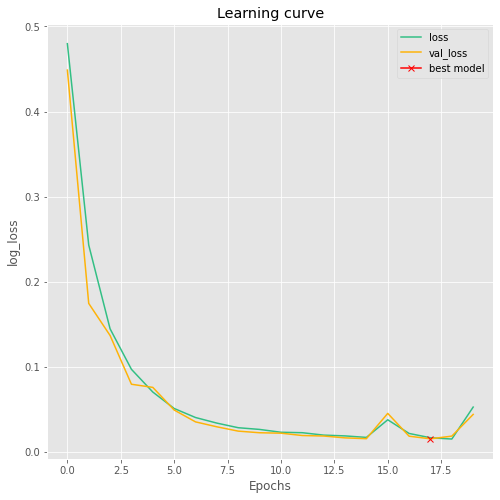

In [76]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss", color=sns.xkcd_rgb['greenish teal'])
plt.plot(results.history["val_loss"], label="val_loss", color=sns.xkcd_rgb['amber'])
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
# plt.grid(False)
plt.show()

## Prediction

In [77]:
# load the best model
model.load_weights('model-brain-mri.h5')

In [78]:
eval_results = model.evaluate(valid_gen, steps=STEP_SIZE_VALID, verbose=1)

30/30 [==============================] - 4s 130ms/step - loss: 0.0163 - accuracy: 0.9949


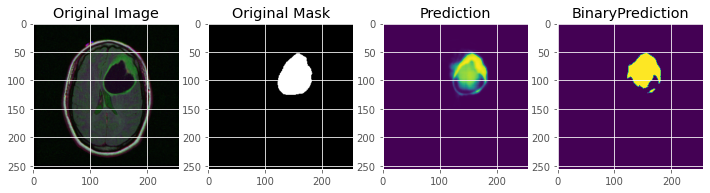

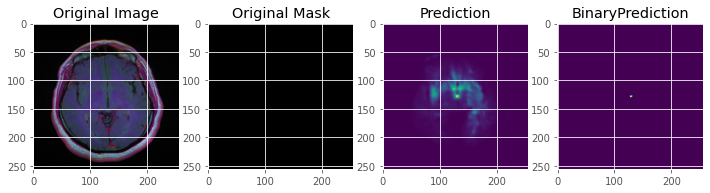

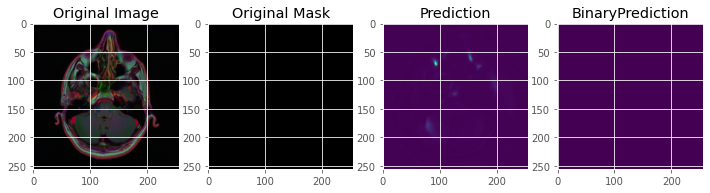

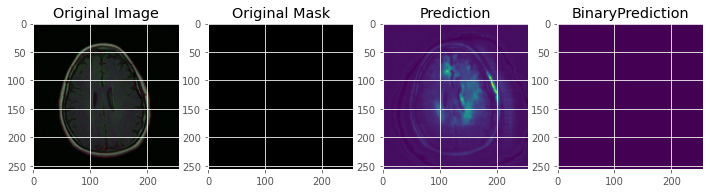

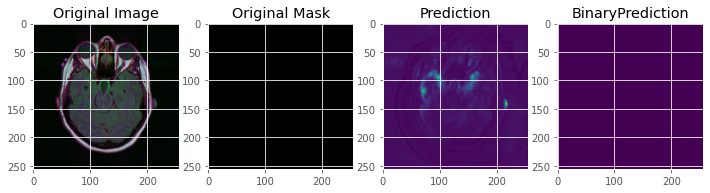

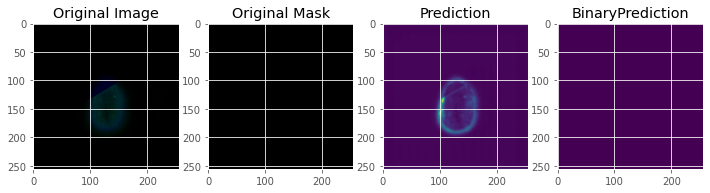

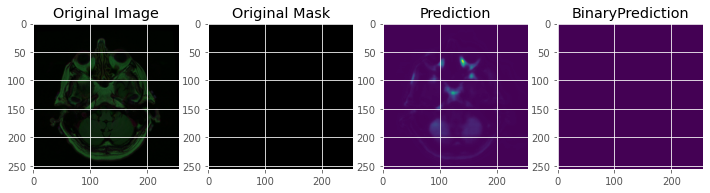

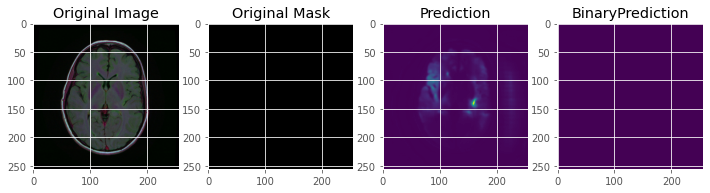

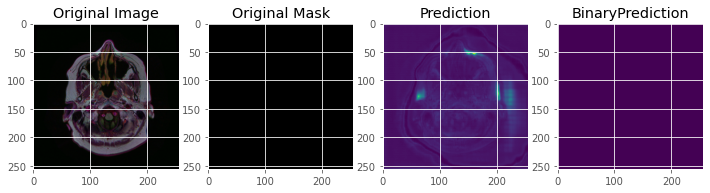

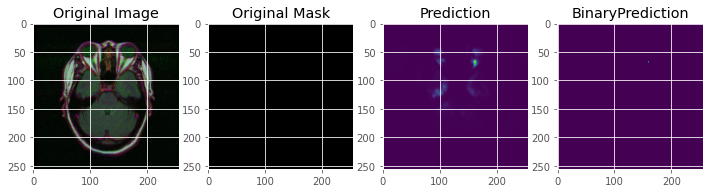

In [79]:
for i in range(10):
    idx = np.random.randint(0, len(imagePath_df))
    
    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    img = cv2.resize(image ,(ImgHieght, ImgWidth))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,4,2)
    plt.imshow(mask)
    plt.title('Original Mask')
    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(pred))
    plt.title('Prediction')
    plt.subplot(1,4,4)
    plt.imshow(np.squeeze(pred) > 0.5)
    plt.title('BinaryPrediction')
    plt.show()